In [142]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# %matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

In [143]:
import warnings
warnings.filterwarnings('ignore')

In [144]:
df = pd.read_csv('bengaluru_house_prices.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [145]:
df.shape    

(13320, 9)

In [146]:
df.groupby('area_type')['area_type'].agg('count') 

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [147]:
df1 = df.drop(['area_type','availability','society','balcony'], axis = 'columns')
df1.shape
df1.head()


,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [148]:
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
BHK           0
dtype: int64

In [149]:
df1.isnull().sum()                      # It shows the number of rows in columns which are having "na" values.

df2 = df1.dropna()                     # dropna function is used to drop all such rows.
df2.isnull().sum()

df2.shape

(13246, 5)

In [150]:

df2['size'].unique()         # The problem in this series is 4BHK = 4 bedroom, but still they are taken as different. So, we've to remove the words.

df2['BHK'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))          # Splitted the string on the basis of the space(' ') and taken the value before space as our main value 
                                                                        # (using [0])
df2.head()

df2['BHK'].unique()


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [151]:
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

df2[~df2['total_sqft'].apply(is_float)].head()          # It is showing those rows in which total_sqft data is non_uniform.

def convert_sqft_to_num(x):
  tokens = x.split('-')
  if len(tokens) == 2:
    return (float(tokens[0]) + float(tokens[1]))/2
  try:
    return float(x)
  except:
    return None

convert_sqft_to_num('2100-2850')

convert_sqft_to_num('2100')

convert_sqft_to_num('34.46Sq. Meter')

df3 = df2.copy()
df3['total_sqft'] = df3['total_sqft'].apply(convert_sqft_to_num)
df3.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [152]:
df4 = df3.copy()
df4['price_per_sqft'] = df4['price']*100000/df4['total_sqft']
df4.head()

df4.location = df4.location.apply(lambda x: x.strip())
location_stats = df4.groupby('location')['location'].agg('count').sort_values(ascending = False)
location_stats


location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [153]:
len(location_stats[location_stats <= 10])     # It shows the number of location_stats with <= 10 data points.

location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

len(df4.location.unique())

df4.location = df4.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df4.location.unique())

242

In [154]:
df4[df4.total_sqft/df4.BHK < 300].head()

df4.shape

df5 = df4[~(df4.total_sqft/df4.BHK < 300)]
df5.shape


(12502, 7)

In [155]:
def remove_pps_outliers(df):
  df_out = pd.DataFrame()
  for key, subdf in df.groupby('location'):
    m = np.mean(subdf.price_per_sqft)
    st = np.std(subdf.price_per_sqft)
    reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
    df_out = pd.concat([df_out, reduced_df], ignore_index = True)

  return df_out

df6 = remove_pps_outliers(df5)
df6.shape

(10241, 7)

Text(0, 0.5, 'Count')

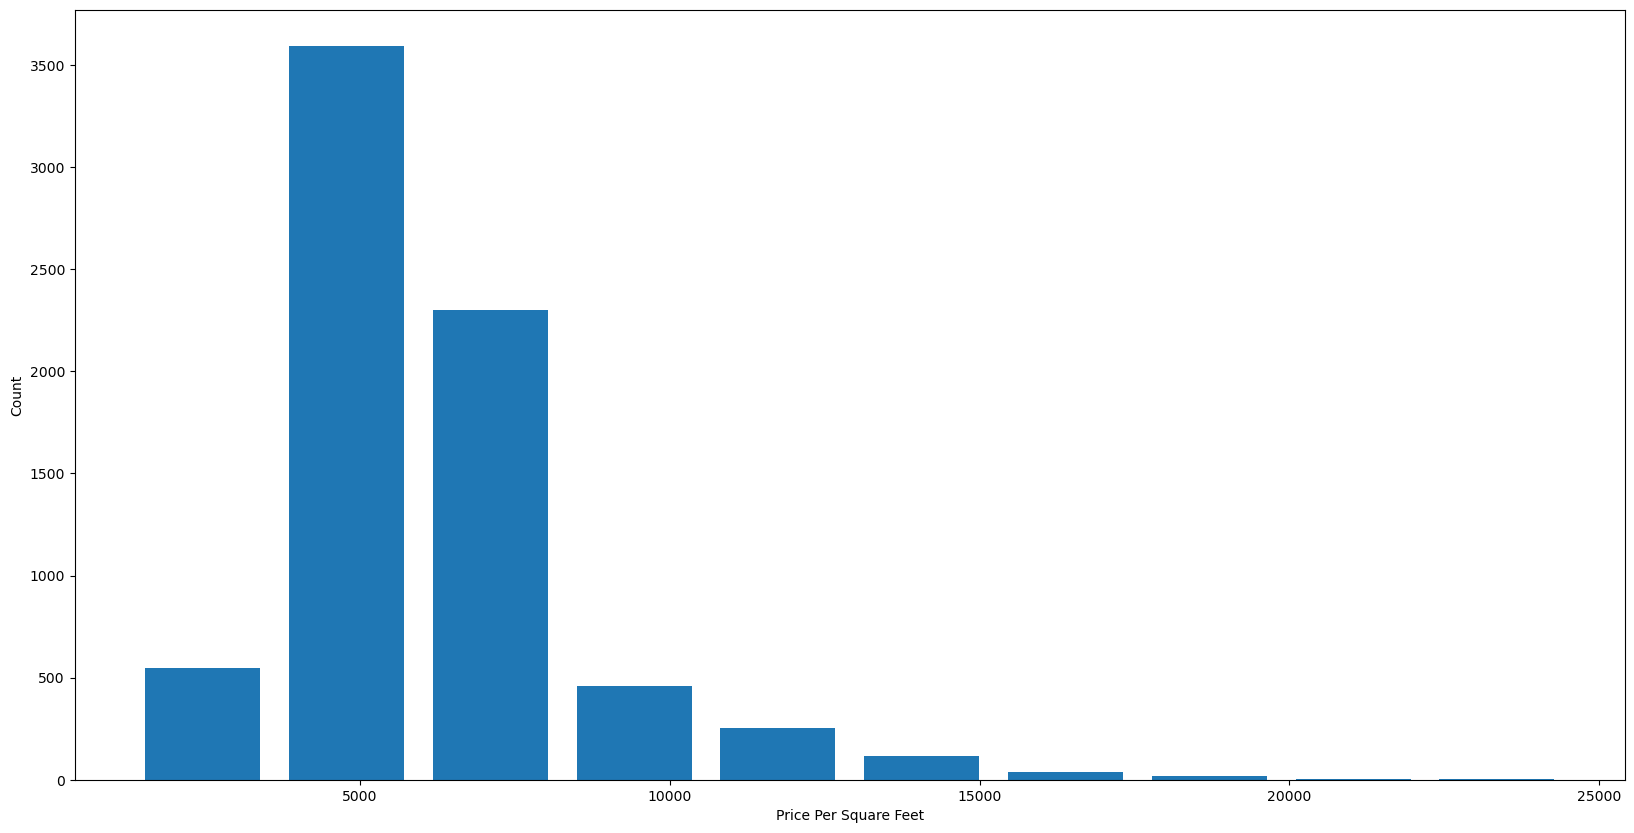

In [156]:
def remove_bhk_outliers(df):
  exclude_indices = np.array([])
  for location, location_df in df.groupby('location'):
    bhk_stats = {}
    for bhk, bhk_df in location_df.groupby('BHK'):
      bhk_stats[bhk] = {
          'mean' : np.mean(bhk_df.price_per_sqft),
          'std' : np.std(bhk_df.price_per_sqft),
          'count' : bhk_df.shape[0]
      }
    for bhk, bhk_df in location_df.groupby('BHK'):
      stats = bhk_stats.get(bhk - 1)
      if stats and stats['count'] > 5:
        exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
      
  return df.drop(exclude_indices,axis='index')

df7 = remove_bhk_outliers(df6)
df7.shape

import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df7.price_per_sqft, rwidth = 0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")


In [157]:
df8 = df7[df7.bath < df7.BHK + 2]
df8.shape


(7251, 7)

In [158]:
"""## Remove unnecessary columns: Price_per_sqft and size"""

df9 = df8.drop(['size','price_per_sqft'], axis = 'columns')
df9.shape
df9.head()

,location,total_sqft,bath,price,BHK
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [159]:


dummies = pd.get_dummies(df9.location)
dummies.head(3)

df10 = pd.concat([df9, dummies.drop('other', axis = 'columns')], axis = 'columns')     # Dropping of column is required for avoiding trapping due to dummies variable.
df10.head(2)


,location,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
df11 = df10.drop('location', axis = 'columns')
df11.head(2)

x = df11.drop('price', axis = 'columns')            # dataframe containing only independent variables.
x.head(3)

y = df11.price                # dataframe containing only dependent variable.
y.head(3)


0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [161]:

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)   # 0.2 = 20% of total data will be used for testing and rest 80 for training the model.

from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(x_train, y_train)
lr_clf.score(x_test, y_test)

0.8452277697874312

In [162]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)

cross_val_score(LinearRegression(), x, y, cv = cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [163]:

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(x, y):
  algos = {
      'linear_regression' : {
          'model' : LinearRegression(),
          'params' : {
              
          }
      },
      'lasso' : {
          'model' : Lasso(),
          'params' : {
              'alpha' : [1, 2],
              'selection' : ['random', 'cyclic']
          }
      },
      'decision_tree' : {
          'model' : DecisionTreeRegressor(),
          'params' : {
              'criterion' : ['mse', 'friedman_mse'],
              'splitter' : ['best', 'random']
          }
      }
  }

  scores = []
  cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
  for algo_name, config in algos.items():
    gs = GridSearchCV(config['model'], config['params'], cv = cv, return_train_score = False)
    gs.fit(x, y)
    scores.append({
        'model' : algo_name,
        'best_score' : gs.best_score_,
        'best_params' : gs.best_params_
    })

  return pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])

find_best_model_using_gridsearchcv(x, y)


,model,best_score,best_params
0,linear_regression,0.818354,{}
1,lasso,0.687429,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.714401,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [164]:
def predict_price(location, sqft, bath, bhk):
  loc_index = np.where(x.columns == location)[0][0]

  X = np.zeros(len(x.columns))
  X[0] = sqft
  X[1] = bath
  X[2] = bhk
  if loc_index >= 0:
    X[loc_index] = 1

  return lr_clf.predict([X])[0]

predict_price('1st Phase JP Nagar', 1000, 2, 2)

predict_price('Indira Nagar', 1000, 2, 2)



181.2781548400685

In [165]:

import pickle 
from pathlib import Path

# Train model
lr_clf = ... 

# Save model
model_file = Path('C:\\Users\\spars\\Desktop\\projectsbangalore_home_price_model.pkl') 
with open(model_file, 'wb') as f:
    pickle.dump(lr_clf, f)

# Save column metadata 
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]  
}
column_file = Path('columns.json')
with open(column_file, 'w') as f:
    json.dump(columns, f)